In [ ]:
'''This notebook allows you to build a time series model. Predict the daily behavior of the series in the next 3 months.'''

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Load data
data = pd.read_excel(r"C:\Users\Admin\WORK\Time_series_analysis\data\task_1_2.xlsx", sheet_name="Timeseries")
data = data.rename(columns={'Date': 'date', 'series1': 'series'})
data['date'] = pd.to_datetime(data['date'])                        # change to datetime object (datetime64)
data.set_index('date', inplace=True)                               # pick column "Date" how label (inplace=True  for don't creating new df)

In [ ]:
# dataframe information
print(data)
print(data.describe())
print("\nКоличество нулевых значений в каждом столбце:")
print("None:", data.isnull().sum(), "\nNaN:", data.isna().sum())

                 series
date                   
2015-01-01  1006.699649
2015-01-02  3197.751826
2015-01-03  3217.491035
2015-01-04  2151.573759
2015-01-05  4243.929892
...                 ...
2019-06-26  4007.059387
2019-06-27  4836.106157
2019-06-28  4895.323783
2019-06-29  4086.016222
2019-06-30  3572.796793

[1642 rows x 1 columns]
             series
count   1642.000000
mean    3854.975154
std     1237.337605
min      236.870506
25%     3138.534200
50%     3632.014420
75%     4258.734299
max    12652.832842

Количество нулевых значений в каждом столбце:
None: series    0
dtype: int64 
NaN: series    0
dtype: int64


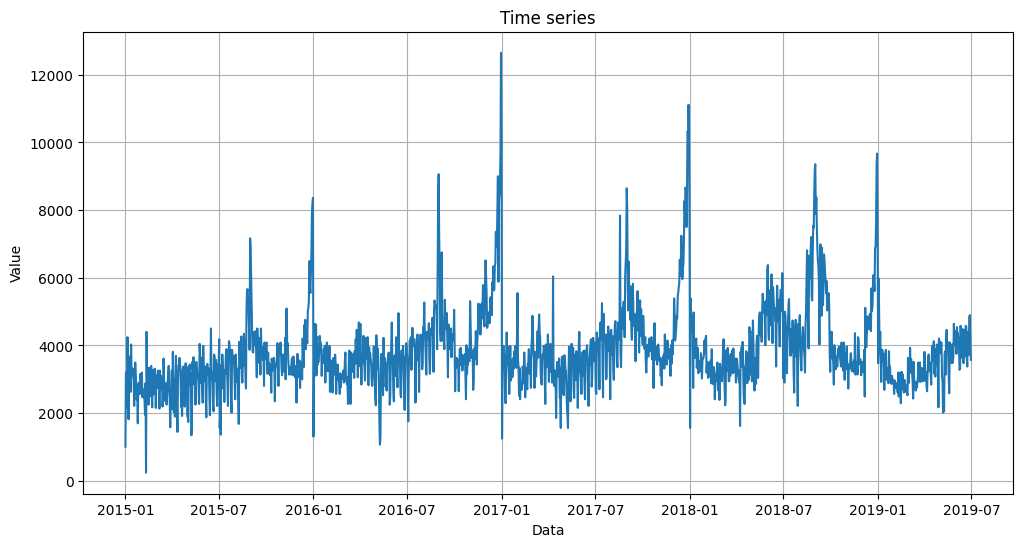

In [28]:
#visualization time series for checking of trend

plt.figure(figsize=(12, 6))
plt.plot(data)
plt.title("Time series")
plt.xlabel("Data")
plt.ylabel("Value")
plt.grid()
plt.show()

In [ ]:
# for estimating stationarity of time series
result = adfuller(data['series'])  
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -5.496713808722672
p-value: 2.1154012725975373e-06
